## Compare Spectra for each case with the theoretical, predicted spectra

In [1]:
import tqdm
import time
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


import sys
stormtrack = 1
if stormtrack == 0:
    usr = "gliu"
    datpath = "/Users/%s/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/01_Data/model_input/" % usr
    sys.path.append("/Users/%s/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/03_Scripts/stochmod/model/"% usr)
    sys.path.append("/Users/%s/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/"% usr)
elif stormtrack == 1: # NOTE... need to edit this
    datpath = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/HMXL/"
    sys.path.append("/home/glliu/00_Scripts/01_Projects/00_Commons/")
    sys.path.append("/home/glliu/00_Scripts/01_Projects/01_AMV/02_stochmod/stochmod/model/")

import scm
from amv import proc,viz

In [2]:
# Paths, User Inputs
outpath = "/stormtrack/data3/glliu/02_Figures/20210715/"
datpath = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/NHFLX/"
"""
-rw-rw-r-- 1 glliu glliu 4.5G Apr 25 17:37 NHFLX_PIC_Full.npy
-rw-rw-r-- 1 glliu glliu 1.9G Feb  2 22:57 NHFLX_PIC.nc
-rw-rw-r-- 1 glliu glliu 1.8G Feb 19 01:18 NHFLX_PIC_SLAB_raw.nc
-rw-rw-r-- 1 glliu glliu 1.3G Feb 19 02:09 TS_PIC_SLAB_raw.nc
"""


#datpath = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/01_hfdamping/hfdamping_PIC_SLAB/02_ENSOREM/"

"""
-rw-rw-r-- 1 glliu glliu 2.3G Nov 15  2020 ENSOREM_TS_lag1_pcs2_monwin3.npz
-rw-rw-r-- 1 glliu glliu 2.3G Mar 19 04:19 ENSOREM_NHFLX_lag1_pcs2_monwin3.npy
"""


# Constants
rho   = 1026
cp0   = 3996
mons3 = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')


# Load Latlon
datpath2 = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Model_Data/model_input/"

# Load lat/lon
from scipy.io import loadmat
mt = loadmat("/home/glliu/01_Data/CESM1_LATLON.mat")
lat = mt["LAT"].squeeze()#np.load(datpath2+"../lat.npy")
lon36 = mt["LON"].squeeze()#np.load(datpath2+"../lon.npy")
lon,_ = proc.lon360to180(lon36,np.ones((288,192,1)))


lonf = -30
latf = 50
klon,klat = proc.find_latlon(lonf,latf,lon,lat)

Closest lon to -30.00 was -30.00
Closest lat to 50.00 was 50.42


## Load SST, NHFLX

In [3]:
%%time

# Load SST from SLAB

ds   = xr.open_dataset(datpath+"TS_PIC_SLAB_raw.nc")
dspt = ds.sel(lon=330,lat=50,method='nearest')
T   = dspt.TS.values
dspt

CPU times: user 245 ms, sys: 27.2 ms, total: 273 ms
Wall time: 271 ms


<xarray.Dataset>
Dimensions:  (time: 10812)
Coordinates:
    lev      float64 ...
    lat      float64 50.42
    lon      float64 330.0
  * time     (time) object 0101-02-01 00:00:00 ... 1002-01-01 00:00:00
Data variables:
    TS       (time) float32 282.09058 280.616 280.64438 ... 284.21448 283.3534
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             e.e11.E1850C5CN.f09_g16.001
    title:            UNSET
    logname:          adrianne
    host:             ys0222
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /glade/p/cesmdata/cseg/inputdata/atm/cam/inic/fv/cami-m...
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...

In [4]:
%%time 
# Load NHFLX from SLAB

ds   = xr.open_dataset(datpath+"NHFLX_PIC_SLAB_raw.nc")
dspt = ds.sel(lon=330,lat=50,method='nearest')
Q  = dspt.NHFLX.values

# Get # of Years
ntime = Q.shape[0]
nyr   = int(ntime/12)

dspt

CPU times: user 358 ms, sys: 16.8 ms, total: 375 ms
Wall time: 373 ms


<xarray.Dataset>
Dimensions:  (time: 10812)
Coordinates:
    lev      float64 ...
    lat      float64 50.42
    lon      float64 330.0
  * time     (time) object 0101-01-01 00:00:00 ... 1001-12-01 00:00:00
Data variables:
    NHFLX    (time) float32 -245.63795 -158.8689 ... -121.01072 -190.09209

Closest lon to 330.00 was 330.00
Closest lat to 50.00 was 50.42
CPU times: user 78 ms, sys: 4.92 s, total: 5 s
Wall time: 5.01 s


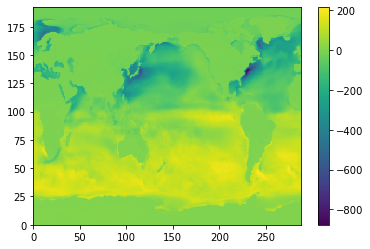

In [5]:
%%time
# Load in data for Qnet, CESM-FULL
Qfull   = np.load(datpath+"NHFLX_PIC_Full.npy")

klon360,_ = proc.find_latlon(lonf+360,latf,lon36,lat)
Qfull.shape, plt.pcolormesh(Qfull[0,0,:,:]),plt.colorbar()

Qfullpt  = Qfull[:,:,klat,klon360]

Qafullpt = Qfullpt - Qfullpt.mean(0)[None,:]


In [6]:
%%time

# Remove monthly anomalies

# Preallocate
v_in  = [T,Q,Qfullpt.flatten()]
v_a   = []
for v in v_in:
    
    v  = v.reshape(int(v.shape[0]/12),12)
    va = v - v.mean(0)[None,:]
    v_a.append(va.flatten())

Ta,Qa,Qafull = v_a


CPU times: user 6.18 ms, sys: 1.37 ms, total: 7.54 ms
Wall time: 4.67 ms


CPU times: user 47.4 ms, sys: 5.13 ms, total: 52.5 ms
Wall time: 49.9 ms


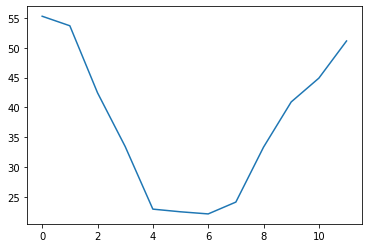

In [7]:
%%time

# Load forcing amplitude
alpha_all = np.load(datpath2+"SLAB_PIC_NHFLXSTD_Forcing_MON.npy")
alpha_all.shape
alpha = alpha_all[klon,klat,:]
plt.plot(alpha)

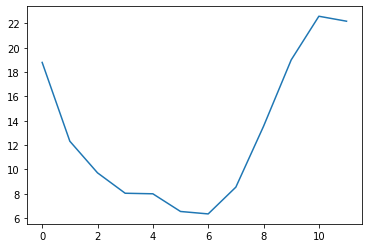

In [8]:
# Load damping

lbd_all = np.load(datpath2+"SLAB_PIC_NHFLX_Damping_monwin3_sig005_dof894_mode4.npy")
lbd = lbd_all[klon,klat,:]
#plt.pcolormesh(lbd_all[:,:,0].T),lbd
plt.plot(lbd)

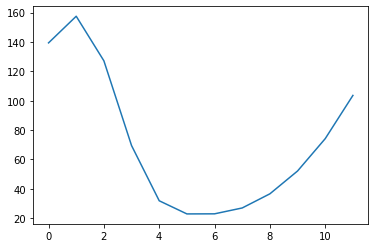

In [9]:
# Load Mixed Layer Depth

mld_all = np.load(datpath2+"HMXL_hclim.npy")
mld     = mld_all[klon,klat,:]
plt.plot(mld)

In [10]:
# Take average lambda and convert to 1/sec
# Calculate stochastic timeseries

#lbd_avg = lbd.mean()
lbd_mon = lbd/(rho*cp0*mld)
lbd_pt = lbd
lbd_avg = lbd_pt.mean() / (rho*cp0*mld.mean())
lbd_winter = (lbd_pt[[1,11,0]] / (rho*cp0*mld[[1,11,0]])).mean()
lbd_summer = (lbd_pt[[5,6,7]] / (rho*cp0*mld[[5,6,7]])).mean()


q       = np.random.normal(0,1,ntime) * np.tile(alpha,int(Qa.shape[0]/12))

print("lbd_avg^-1 is %.3f months" % (1/(lbd_avg*3600*24*30)))
print("lbd_winter^-1 is %.3f months" % (1/(lbd_winter*3600*24*30)))
print("lbd_summer^-1 is %.3f months" % (1/(lbd_summer*3600*24*30)))

lbd_avg^-1 is 8.787 months
lbd_winter^-1 is 11.105 months
lbd_summer^-1 is 5.399 months


In [11]:
lbd_pt[[5,6,7]] / (rho*cp0*mld[[5,6,7]])

array([6.96807553e-08, 6.73655551e-08, 7.73142141e-08])

In [12]:
print((1/(lbd_mon*3600*24*30)))

[11.72592897 20.22454912 20.69637323 13.6632101   6.30053697  5.5367148
  5.72699904  4.99005873  4.27213954  4.3375441   5.19058947  7.38372431]


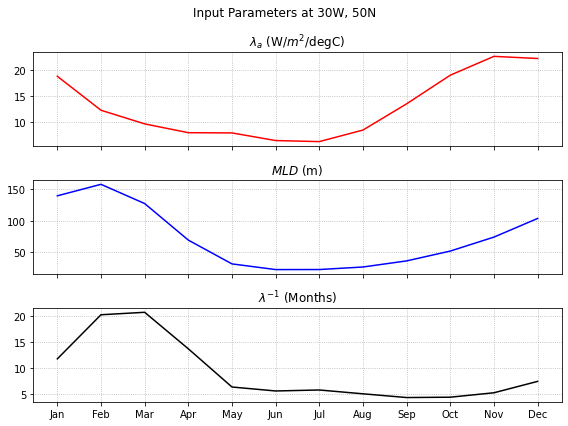

In [13]:
fig,axs= plt.subplots(3,1,sharex=True,figsize=(8,6))


ax = axs[0]
ax.plot(mons3,lbd,color='red')
ax.grid(True,ls='dotted')
ax.set_title("$\lambda_a$ (W/$m^{2}$/degC)")

ax = axs[1]
ax.plot(mons3,mld,color='blue')
ax.set_title("$MLD$ (m)")
ax.grid(True,ls='dotted')

ax = axs[2]
ax.plot(mons3,1/(lbd_mon*3600*24*30),color='k')
ax.set_title("$\lambda^{-1}$ (Months)")
ax.grid(True,ls='dotted')

plt.suptitle("Input Parameters at 30W, 50N")
plt.tight_layout()

plt.savefig("%sDamping_Monthly_Timescales_30W50N.png"%outpath,dpi=200)

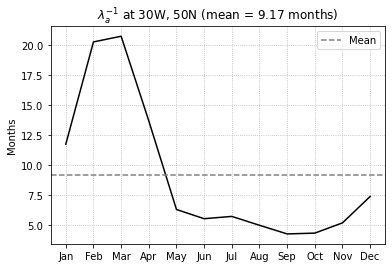

In [14]:

# Underestimation
# Plot just the timescale
fig,ax = plt.subplots(1,1)
ax.plot(mons3,1/(lbd_mon*3600*24*30),color='k')
ax.set_title("$\lambda_a^{-1}$ at 30W, 50N (mean = %.2f months)" % (np.mean(1/(lbd_mon*3600*24*30))))
ax.axhline(np.mean(1/(lbd_mon*3600*24*30)),color='gray',ls='dashed',label="Mean")
ax.legend()
ax.set_ylabel("Months")
ax.grid(True,ls='dotted')
plt.savefig("%sDecay_Timescale_30W50N.png"%outpath,dpi=200)



In [15]:
#1/(lbd_pt[[10,11,0]]/(rho*cp0*mld[[10,11,0]]*3600*24*30))

## Brief Section to Recreate values from Claude's Document

In [16]:
# Recreate Claude's estimate of correlation b/w q and T given some monthly average
nmons   = 10
ndays   = 5
lbdtest = 1 / (24*3600*30*nmons)
nutest  = 1 / (24*3600*ndays)
t_avg   = 24*3600*30

corrc   = ( (lbdtest * nutest * t_avg**2) / (2*(nutest*t_avg-1)) )**.5
corrc


def calc_Tqcorr(nmons,ndays,dayinmon=30):
    """
    From Frankignoul and Hasselmann (1977, Eq. A7), estimate the correlation between T and q
    after averaging for a given monthly timescale, given...

    Inputs
    ------
        1. nmons NUMERIC : # of months for long timescale lambda
        2. ndays NUMERIC : # of months for short timescale nu
        3. dayinmon INT (optional) : Number of days in the month
        
    Returns corr(T,q)
    """
    # Timescales
    lbdtest = 1/(24*3600*dayinmon*nmons) # Month Timescale
    nutest  = 1/(24*3600*ndays) # Day timescale
    t_avg   = 24*3600*dayinmon
    return ( (lbdtest * nutest * t_avg**2) / (2*(nutest*t_avg-1)) )**.5
    

calc_Tqcorr(10,5),corrc


(0.2449489742783178, 0.2449489742783178)

In [17]:
# Calculate some intermediate coefficients

C = lbdtest*t_avg*2*corrc # Coefficient multiplying (var_q*var_t)^0.5
B = (lbdtest*t_avg)**2

B,C

(0.010000000000000002, 0.048989794855663564)

In [18]:
# Calculate coefficients relating to var(T), var(q)

A1   = np.exp(-lbdtest*t_avg)
A2   = (1-np.exp(-lbdtest*t_avg))/(lbdtest*t_avg)

A1,A2

(0.9048374180359595, 0.9516258196404048)

In [19]:
# Use above coefficients to calculate the variance

# Square coeffiicent for q-tilde and divide by squared coefficient for T
A = (A2**2) / (1-np.exp(-2*lbdtest*t_avg))

A # Number appears to be slightly larger?
#

4.995837495788002

In [20]:
# Return to original equation, plugging in var(T)


Bfin = A*B
Cfin = A**.5*C

Bfin,Cfin

(0.049958374957880025, 0.10949890405794574)

In [21]:
# Calculate underestimation of q

1 + (Bfin-Cfin)

0.9404594708999343

In [22]:
# Make the above into a function

def calc_underestq(lbdtest,corrc,t_avg):
    """
    Based on Claude's note, calculate the underestimation of
    stochastic forcing based on taking monthly averages from CESM
    Inputs
    lbdtest : damping timescale in 1/sec
    corrc   : coefficient of corr(T,q)
    t_avg   : conversion timestep in seconds
    
    """
    # First 2 coefficients
    C = lbdtest*t_avg*2*corrc # Coefficient multiplying (var_q*var_t)^0.5
    B = (lbdtest*t_avg)**2    # Coefficient multiplying var(T)
    
    
    # Calculate coefficients relating to T, q from integration
    A1   = np.exp(-lbdtest*t_avg)
    A2   = (1-np.exp(-lbdtest*t_avg))/(lbdtest*t_avg)

    # Calculate var(T) coefficient (taking var of discretized eqn)
    A = (A2**2) / (1-np.exp(-2*lbdtest*t_avg))

    # Plug in var(T) to original coefficients
    Bfin = A*B
    Cfin = A**.5*C
    
    # Sum coefficients of q 
    underest = 1 + (Bfin-Cfin)
    
    return underest

calc_underestq(lbdtest,corrc,t_avg)

0.9404594708999343

## Test Function with Lambda values at the point

In [23]:

lbd_mon_conv = 1/(lbd_mon*3600*24*30) # Convert timescales to months
corrc        = calc_Tqcorr(lbd_mon_conv,ndays,dayinmon=30)
underest     = calc_underestq(lbd_mon,corrc,t_avg)




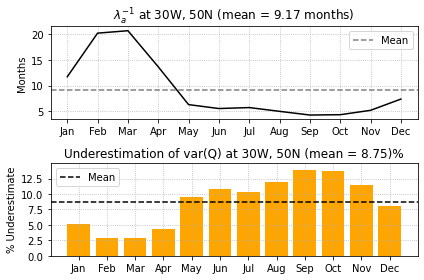

In [24]:
# Plot Results

# Underestimation
# Plot just the timescale
fig,axs = plt.subplots(2,1)

ax = axs[0]
ax.plot(mons3,1/(lbd_mon*3600*24*30),color='k')
ax.set_title("$\lambda_a^{-1}$ at 30W, 50N (mean = %.2f months)" % (np.mean(1/(lbd_mon*3600*24*30))))
ax.axhline(np.mean(1/(lbd_mon*3600*24*30)),color='gray',ls='dashed',label="Mean")
ax.legend()
ax.set_ylabel("Months")
ax.grid(True,ls='dotted')
plt.savefig("%sDecay_Timescale_30W50N.png"%outpath,dpi=200)

ax = axs[1]
ax.bar(mons3,(1-underest)*100,color='orange')
ax.set_title("Underestimation of var(Q) at 30W, 50N (mean = %.2f)" % ((1-np.mean(underest))*100)+"%")
ax.axhline((1-np.mean(underest))*100,color='black',ls='dashed',label="Mean")
ax.set_ylim([0,15])
ax.set_yticks(np.arange(0,15,2.5))
ax.legend()
ax.set_ylabel("% Underestimate")
ax.grid(True,ls='dotted')
plt.tight_layout()
plt.savefig("%sDecay_Timescale_30W50N.png"%outpath,dpi=200)


In [25]:
lbdtest

3.858024691358025e-08

In [26]:
lbd_mon

array([3.29016550e-08, 1.90759491e-08, 1.86410665e-08, 2.82365905e-08,
       6.12332680e-08, 6.96807553e-08, 6.73655551e-08, 7.73142141e-08,
       9.03066170e-08, 8.89449099e-08, 7.43272939e-08, 5.22503892e-08])

In [27]:
# Calculate the spectra
nsmooth = [250,250,250]
pct     = 0.10

specs,freqs,CCs,dofs,r1s = scm.quick_spectrum(v_a,nsmooth,pct)

Warning, window does not sum to 1!
Warning, window does not sum to 1!
Warning, window does not sum to 1!


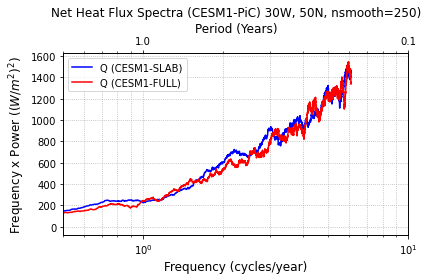

In [28]:
# Plot the spectra comparing slab and full heat fluxes(from analysis/plot_spectra_Generals.py)

# Plotting Params
plotdt = 3600*24*365
xtick  = [float(10)**(x) for x in np.arange(-4,2)]
#ylm    = [-.01,.5]
xlm    = [5e-1,10]
titles = ("Varying Damping and Forcing (Levels 1-3)",
          "Varying Mixed-Layer Depth (Levels 3-5)")
plotconf=False

# Plotting params (SPECIFIC TO THIS SCRIPT)
nplot=len(freqs)
ecolors = ["gray","blue","red"]
enames = ["T","Q (CESM1-SLAB)","Q (CESM1-FULL)"]

fig,ax = plt.subplots(1,1,figsize=(6,4))
  
for n in [1,2]:
    ax.semilogx(freqs[n]*plotdt,specs[n]*freqs[n],color=ecolors[n],label=enames[n])

if plotconf:
    ax.semilogx(freqs[n]*plotdt,CCs[n][:,1]*freqs[n],color=ecolors[n],alpha=0.5,ls='dashed')
    ax.semilogx(freqs[n]*plotdt,CCs[n][:,0]*freqs[n],color=ecolors[n],alpha=0.5,ls='dotted')

# Set Labels
ax.set_ylabel("Frequency x Power ($(W/m^2)^{2}$)",fontsize=12)
ax.set_xlabel("Frequency (cycles/year)",fontsize=12)
htax = viz.twin_freqaxis(ax,freqs[1],"Years",plotdt,mode='log-lin',xtick=xtick)

# Set upper x-axis ticks
xtick2 = htax.get_xticks()
xtkl = ["%.1f" % (1/x) for x in xtick2]
htax.set_xticklabels(xtkl)
    
# Set axis limits
ax.set_xlim(xlm)
htax.set_xlim(xlm)
#ax.set_ylim(ylm)
#htax.set_ylim(ylm)
    
ax.legend(fontsize=10)
#ax.set_title(titles[i])
    
locstring= "30W, 50N"
ax.set_title("Net Heat Flux Spectra (CESM1-PiC) %s, nsmooth=%i)"%(locstring,nsmooth[1]))
ax.grid(True,which='both',ls='dotted')
plt.tight_layout()


plt.savefig("%sNHFLX_Spectra_Comparison_CESM-PIC_nsmooth%i_lon-30_lat50_Ann.png"%(outpath,nsmooth[1]),dpi=200)

In [29]:
# calculate spectra for other things
nsmooth = [500,500,500]
taper   = 0.1

specs,freqs,CCs,dofs,r1s = scm.quick_spectrum([Ta,Qa,q],nsmooth,pct)
 

Warning, window does not sum to 1!
Warning, window does not sum to 1!
Warning, window does not sum to 1!


In [45]:
# Calculate Theoretical

Fqq0 = specs[2][0] # Take value of Fqq at zero
#Fqq0 = specs[1][0]
omega = freqs[0]

Qth = Fqq0 * (omega**2 / (omega**2+lbd_avg**2))
QthQQ = (Fqq0+(1-underest.max())*Fqq0) * (omega**2 / (omega**2+lbd_avg**2)) # Rescale by 6% to re-estimate the values
Qth_winter = Fqq0 * (omega**2 / (omega**2+lbd_winter**2))
Qth_summer = Fqq0 * (omega**2 / (omega**2+lbd_summer**2))


In [46]:
underest.max()

0.9712299434840601

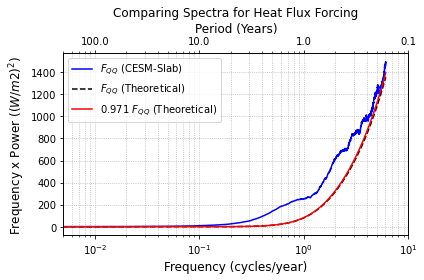

In [47]:
# Plot the spectra (from analysis/plot_spectra_Generals.py)

# Plotting Params
plotdt = 3600*24*365
xtick  = [float(10)**(x) for x in np.arange(-4,2)]
#ylm    = [-.01,.5]
xlm    = [5e-3,10]
titles = ("Varying Damping and Forcing (Levels 1-3)",
          "Varying Mixed-Layer Depth (Levels 3-5)")
plotconf=False

# Plotting params (SPECIFIC TO THIS SCRIPT)
nplot=len(freqs)
ecolors = ["gray","blue","orange"]
enames = ["T","$F_{QQ}$ (CESM-Slab)","$F_{qq}$ (Applied)"]

fig,ax = plt.subplots(1,1,figsize=(6,4))
  
for n in [1]:
    ax.semilogx(freqs[n]*plotdt,specs[n]*freqs[n],color=ecolors[n],label=enames[n])

if plotconf:
    ax.semilogx(freqs[n]*plotdt,CCs[n][:,1]*freqs[n],color=ecolors[n],alpha=0.5,ls='dashed')
    ax.semilogx(freqs[n]*plotdt,CCs[n][:,0]*freqs[n],color=ecolors[n],alpha=0.5,ls='dotted')
    
ax.semilogx(omega*plotdt,Qth*omega,color="k",ls='dashed',label="$F_{QQ}$ (Theoretical)")
ax.semilogx(omega*plotdt,QthQQ*omega,color="red",ls='solid',label="%.3f $F_{QQ}$ (Theoretical)" % (underest.max()))
#ax.semilogx(omega*plotdt,Qth_winter*omega,color="red",ls='dashed',label="$F_{QQ}$ (Theoretical, Winter)") 
#ax.semilogx(omega*plotdt,Qth_summer*omega,color="magenta",ls='dashed',label="$F_{QQ}$ (Theoretical, Summer)") 

# Set Labels
ax.set_ylabel("Frequency x Power ($(W/m2)^{2}$)",fontsize=12)
ax.set_xlabel("Frequency (cycles/year)",fontsize=12)
htax = viz.twin_freqaxis(ax,freqs[1],"Years",plotdt,mode='log-lin',xtick=xtick)

# Set upper x-axis ticks
xtick2 = htax.get_xticks()
xtkl = ["%.1f" % (1/x) for x in xtick2]
htax.set_xticklabels(xtkl)
    
# Set axis limits
ax.set_xlim(xlm)
htax.set_xlim(xlm)
# ax.set_ylim(ylm)
# htax.set_ylim(ylm)
    
ax.legend(fontsize=10)
#ax.set_title(titles[i])
    
locstring= "30W, 50N"
ax.set_title("Comparing Spectra for Heat Flux Forcing")
ax.grid(True,which='both',ls='dotted')
plt.tight_layout()


plt.savefig("%sNHFLX_Spectra_Theoretical_CESM-PIC_nsmooth%i_lon-30_lat50_Ann.png"%(outpath,nsmooth[1]),dpi=200)

In [19]:
(specs[1][0]*omega**2 / (omega**2+lbd_avg**2)),freqs[1],freqs[2]

(array([1.45401259e+03, 5.81603883e+03, 1.30860441e+04, ...,
        2.09293590e+09, 2.09297407e+09, 2.09301222e+09]),
 array([3.56828033e-11, 7.13656066e-11, 1.07048410e-10, ...,
        1.92829869e-07, 1.92865552e-07, 1.92901235e-07]),
 array([3.56828033e-11, 7.13656066e-11, 1.07048410e-10, ...,
        1.92829869e-07, 1.92865552e-07, 1.92901235e-07]))

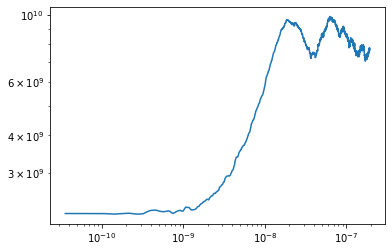

In [31]:
plt.loglog(freqs[1],specs[1])

In [109]:
%%time
# Load in data for Qnet, CESM-FULL
Qfull   = np.load(datpath+"NHFLX_PIC_Full.npy")

klon360,_ = proc.find_latlon(lonf+360,latf,lon36,lat)
Qfull.shape, plt.pcolormesh(Qfull[0,0,:,:]),plt.colorbar()

Qfullpt = Qfull[:,:,klat,klon360]

Qafullpt = Qfullpt - Qfullpt.mean(0)[None,:]

#dfpt = df.sel(lon=330,lat=50,method='nearest')
#Qfull  = dfpt.NHFLX.values
#dfpt

CPU times: user 0 ns, sys: 4.11 s, total: 4.11 s
Wall time: 4.11 s


Closest lon to 330.00 was 330.00
Closest lat to 50.00 was 50.42


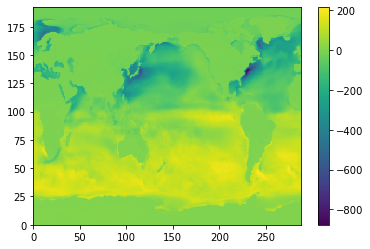

array([ 1.2762396e-04, -6.1751074e-05,  1.6184398e-05, -2.7196397e-06,
       -5.5240034e-05,  5.0982657e-05,  6.2293308e-05, -2.2282407e-05,
        1.5144412e-05,  1.9473808e-05, -1.2043514e-05,  4.6810001e-06],
      dtype=float32)